In [1]:
module('load', 'pytorch/gpu-cuda-12.1/2.2.0')
import torch.nn.functional as F



Loading pytorch/gpu-cuda-12.1/2.2.0
  Loading requirement: cuda/12.1 cudnn/8.9.2


In [2]:
main_lens_dict={
    "system_index": 11,
    "precomputed": {
        "D_l": 1787.8262293384223,
        "D_s": 1539.2009840358578,
        "D_ls": 449.9684790307436,
        "Theta_E": 5.954515276371751e-06
    },
    "lens_model": {
        "num_substructures": 0,
        "mass_components": [
            {
                "type": "PEMD",
                "is_substructure": False,
                "params": {
                    "pos": [
                        0.0,
                        0.0
                    ],
                    "redshift": 1.7629021821047843,
                    "vel_disp": 381.676655549674,
                    "slope": 1.1386734630729884,
                    "orient": [
                        0.9017743025951793
                    ],
                    "q": [
                        0.5384704819933674
                    ]
                }
            }
        ]
    },
    "source_model": {
        "type": "Gaussian_blob",
        "params": {
            "I": 1.0,
            "position_rad": [
                5.468951500607737e-07,
                7.709517743986199e-07
            ],
            "orient_rad": 0.0,
            "q": 0.8,
            "std_kpc": 0.8,
            "redshift": 3.534926168256522
        }
    }
}


sub_dict= {
    "type": "NFW",
    "is_substructure": True,
    "params": {
        "pos": [
            9.483614740698115e-06,
            8.167519092202279e-06
        ],
        "mass_max": 2614350859.4532137,
        "r_max_kpc": 3.5158737851037714,
        "redshift": 1.7629021821047843
    }
}

In [3]:
import numpy as np
from shared_utils import units
import astropy.units as u


def get_r_max_from_M_max(M_max):
    M_max=M_max*u.M_sun
    A=0.344*u.kpc #kpc
    B=1.607
    const_1=(np.log(2.163+1.)+1/(2.163+1)-1)*4*np.pi
    #print(const_1)    
    from astropy.constants import G
    G = G.to(u.kpc * u.km**2/u.s**2 / u.M_sun)
    const_2=(10* u.km/u.s     /1.64/np.sqrt(G)   *(2.163/A)**(1/B)    )**2
    #print(const_2)
    r_s=((M_max/const_1/const_2).to(u.kpc**(1 + 2/B)))**(B/(B+2))
    r_max=2.163*r_s
    return r_max.to(u.kpc).value

In [4]:
from lensing_system import LensModel as LensModelNonBatched
from lensing_system_broadcasting import LensModel
from lensing_system_broadcasting import SourceModel
from shared_utils import recursive_to_tensor
import torch
from substructure_classifier.substructure_classifier_development import SubstructureClassifier
from substructure_classifier.training_stage_development import Stage


from shared_utils import _grid_lens
image_grid=_grid_lens(8.0, 1000, device="cuda")
eval_grid=_grid_lens(10.0, 80, device="cuda")


loaded_classifier=SubstructureClassifier(classifier_name="ResnetNoiseHighRes")
#classifier_stage=Stage(classifier_instance=loaded_classifier , stage_id="f150c8927ca739fff70456a01caaedbdc3361c1872381fe1e9a811d2f3e2b83d")
classifier_stage=Stage(classifier_instance=loaded_classifier , stage_id="ed2f9fe85d0faeeb638f4ea5a627ad970c07a319f2b35a1333a24b6a5c396844")

model=classifier_stage.get_model(compiled=True)

cuda
doneStage1
doneStage2
doneStage3
doneStage4
doneStage5
load_stage1
load_stage2
load_stage2.1
load_stage3
load_stage4
load_stage5
load_stage6
doneStage6
doneStage7


In [5]:
import tqdm
from noise_applicator import NoiseApplicator, GaussKernel
import torch.nn.functional as F


class SensMapMaker:
    def __init__(
        self,
        main_lens_dict=main_lens_dict,
        substructure_dict=sub_dict,
        sub_key_changed="mass_max",
        values_key = 10**torch.linspace(7.,12., 14),
        evaluation_grid=eval_grid,
        image_grid=image_grid,
        model=model,
        batch_size=1024
    ):
        self.image_grid=image_grid
        self.evaluation_grid=evaluation_grid
        self.batch_size=batch_size
        self.model=model.to("cuda")
        
        main_lens_dict=recursive_to_tensor(main_lens_dict, device="cuda")
        self.precomp_raw=main_lens_dict["precomputed"] #raw because it will have to be converted to a specific format
        self.source_raw=main_lens_dict["source_model"]
        #1: compute the deflection of the main lens
        main_lens_model = LensModelNonBatched(
            main_lens_dict["lens_model"], 
            precomp_dict=main_lens_dict["precomputed"], 
            device='cuda')

        self.source_redshift = main_lens_dict["source_model"]["params"]["redshift"]
        self.base_deflection = main_lens_model(image_grid, self.source_redshift).unsqueeze(0).repeat(batch_size, 1, 1, 1)

        #2: build the systems made of only one sub properly,
        # : we can't built them all toghether with the current lens class.
        # : but I can prepare the batches of initializations, as well as the sub class
        self.sub_raw=sub_dict
        self.set_sub_params_matrix(evaluation_grid, sub_key_changed, values_key)
        #3: build the source properly: since the source is always the same, 
        #   we could keep only one object, with the params and precomp of the fixed size
        #   of the calculation batch.

        source_data=self.get_source_config(batch_size)
        source_precomp=self.get_expanded_precomp(batch_size)
        
        self.source_model=SourceModel(source_data, source_precomp)

        image=self.source_model(self.base_deflection)
        print(image.shape)
        import matplotlib.pyplot as plt
        
        plt.imshow(image[0].detach().cpu())
        plt.title("base image")
        plt.show()
            
        self.get_logits_matrix()
            
    def set_sub_params_matrix(self, evaluation_grid, sub_key_changed, values_key):
        # thi is a matrix of this shape:
        # if n_p is the number of params of the sub, and n_t the nubmer of values tried
        # [n_p, n_t, shape_eval_grid]
        H, W = evaluation_grid.shape[:2]

        self.n_values=n_values=torch.as_tensor(values_key).shape[0]
        sub_param_map={
            'NFW': ['pos_x', 'pos_y','mass_max','r_max_kpc','redshift'],
        }

        sub_type=self.sub_raw["type"]
        sub_params=self.sub_raw["params"]

        if sub_type not in sub_param_map:
            raise NotImplemented

        if sub_type=='NFW':
            init_tensor=torch.tensor([
                sub_params['pos'][0],
                sub_params['pos'][1],
                sub_params['mass_max'],
                sub_params['r_max_kpc'],
                sub_params['redshift'],

            ], device="cuda")
            
            self.n_params=5
            self.sub_type='NFW'
            params_matrix=torch.empty((self.n_params, n_values, evaluation_grid.shape[0], evaluation_grid.shape[1]))
            params_matrix[0, :, :, :]=evaluation_grid[:,:, 0]
            params_matrix[1, :, :, :]=evaluation_grid[:,:, 1]
            params_matrix[2:] = init_tensor[2:, None, None, None].expand(-1, n_values, H, W)
            #now_fill the rest of the matrix
            
            if sub_key_changed=="mass_max":
                # move to the same device/dtype as your params_matrix
                vals = torch.as_tensor(values_key, device=params_matrix.device, dtype=params_matrix.dtype)
                
                value_r_max=torch.as_tensor(get_r_max_from_M_max(values_key), device=params_matrix.device, dtype=params_matrix.dtype)
                # reshape to (n_values, 1, 1)
                vals = vals.view(n_values, 1, 1)
                value_r_max= value_r_max.view(n_values, 1, 1)

                # Option B: explicitly expand to (n_values, H, W)
                vals_expanded = vals.expand(n_values, H, W)
                value_r_max_expanded=value_r_max.expand(n_values, H, W)
                params_matrix[2] = vals_expanded
                params_matrix[3] = value_r_max_expanded

            
            else:
                raise NotImplemented
                
            self.params_matrix=params_matrix


    def get_logits_matrix(self):
        
        #initialize the logits matrix
        all_logits=[]
        bs=self.batch_size
        flat = self.params_matrix.permute(1, 2, 3, 0)  
        flat = flat.reshape(-1, self.n_params)  
        shared_precomp=self.get_expanded_precomp(bs)
        self.model.eval()
        
        H, W = self.evaluation_grid.shape[:2]
        
        tot_im_to_comp=flat.shape[0]
        
        #Noise
        
        sky_level=0.05
        kernel_size=5
        kernel_sigma=1.0
        gain=500
        
        gauss_kernel = GaussKernel(kernel_size, sigma=kernel_sigma, device="cuda").get_kernel()
        self.psf_and_poisson_noise = NoiseApplicator(apply_poisson=True,
                                                    sky_level=sky_level,
                                                    gain=gain,
                                                    psf=gauss_kernel,
                                                    device="cuda")
        
        
        #strategy with last batch:just pad and slice away

        with torch.no_grad():
            for i in tqdm.tqdm(range(0, flat.shape[0], bs)):
                is_last_batch=i+bs> tot_im_to_comp
                if is_last_batch:
                    batch_params = flat[i:i+bs]   
                    cur_bs = batch_params.size(0)
                    last_row = batch_params[-1:]
                    padding  = last_row.expand(bs - cur_bs, -1)
                    batch_params = torch.cat([batch_params, padding], dim=0)
                else:
                    batch_params = flat[i:i+bs]      
                    
                sub_init=self.get_sub_init(batch_params, self.sub_type)
                sub_model=LensModel(
                    bs,
                    sub_init,
                    shared_precomp
                )

                sub_deflection = sub_model.deflection_field(self.image_grid)
                source_grid=self.base_deflection+sub_deflection
                no_noise_image_batch=self.source_model(source_grid).unsqueeze(1)
                
                no_noise_image_batch2=F.avg_pool2d(no_noise_image_batch, kernel_size=5, stride=5)

                
                images= self.psf_and_poisson_noise.apply(no_noise_image_batch2)

                
                

                logits = self.model(images).detach().cpu()         # -> [<=bs, 2]
                if is_last_batch:
                    all_logits.append(logits[:cur_bs])

                else:
                    all_logits.append(logits)

        all_logits = torch.cat(all_logits, dim=0)  # [n_values*H*W, 2]

        
        logits_matrix = all_logits.view(self.n_values, H, W, 2)
        self.logits_matrix = logits_matrix.permute(3, 0, 1, 2)
        
        
    def get_sub_init(self, parameters_batch, sub_type):
        sub_param_map={
            'NFW': ['pos_x', 'pos_y','mass_max','r_max_kpc','redshift'],
        }
        sub_init= {
            sub_type:{
                'sys_idx':   torch.arange(0, parameters_batch.shape[0], device="cuda"),
                'params':    parameters_batch,
                'param_map': sub_param_map[sub_type]
            }
        }
        return sub_init

    

            
    def get_expanded_precomp(self, n_samples):
        precomp_map = ['D_l', 'D_s', 'D_ls', 'Theta_E']
        params=torch.tensor([[
             self.precomp_raw['D_l'], 
             self.precomp_raw['D_s'], 
             self.precomp_raw['D_ls'], 
             self.precomp_raw['Theta_E'] 
        ]], device="cuda")

        precomp_processed = {
            'sys_idx':   torch.arange(0, n_samples, device="cuda"),
            'params': params.repeat(n_samples, 1),
            'param_map': precomp_map
        }

        return precomp_processed


    def get_source_config(self, n_samples):
        source_param_map={
            'Gaussian_blob': ['position_rad_x', 'position_rad_y', 'I' ,'orient_rad','q','std_kpc','redshift']
        }

        source_type=self.source_raw["type"]
        source_params=self.source_raw["params"]

        if source_type not in source_param_map:
            raise NotImplemented

        if source_type=='Gaussian_blob':
            init_tensor=torch.tensor([[
                source_params['position_rad'][0],
                source_params['position_rad'][1],
                source_params['I'],
                source_params['orient_rad'],
                source_params['q'],
                source_params['std_kpc'],
                source_params['redshift'],

            ]], device="cuda")

        source_init={
            source_type: 0
        }
        source_init[source_type] = {
            'sys_idx':   torch.arange(0, n_samples, device="cuda"),
            'params':    init_tensor.repeat(n_samples, 1),
            'param_map': source_param_map[source_type]
        }
        return source_init
    def logits_mat_to_detect_thres(self, confidence):
        pass


#a=SensMapMaker()

# First try of the decomposition

In [7]:
main_lens_dict_with_sub={
    "system_index": 11,
    "precomputed": {
        "D_l": 1787.8262293384223,
        "D_s": 1539.2009840358578,
        "D_ls": 449.9684790307436,
        #"Theta_E": 5.954515276371751e-06
    },
    "lens_model": {
        "num_substructures": 0,
        "mass_components": [
            {
                "type": "PEMD",
                "is_substructure": False,
                "params": {
                    "pos": [
                        0.0,
                        0.0
                    ],
                    "redshift": 1.7629021821047843,
                    "vel_disp": 381.676655549674,
                    "slope": 1.1386734630729884,
                    "orient": [
                        0.9017743025951793
                    ],
                    "q": [
                        0.5384704819933674
                    ]
                }
            },
            {
                "type": "NFW",
                "is_substructure": True,
                "params": {
                    "pos": [
                        9.483614740698115e-06,
                        8.167519092202279e-06
                    ],
                    "mass_max": 2614350859.4532137,
                    "r_max_kpc": 3.5158737851037714,
                    "redshift": 1.7629021821047843
                }
            }
        ]
    },
    "source_model": {
        "type": "Gaussian_blob",
        "params": {
            "I": 1.0,
            "position_rad": [
                5.468951500607737e-07,
                7.709517743986199e-07
            ],
            "orient_rad": 0.0,
            "q": 0.8,
            "std_kpc": 0.8,
            "redshift": 3.534926168256522
        }
    }
}



tensor(5.9545e-06, device='cuda:0')


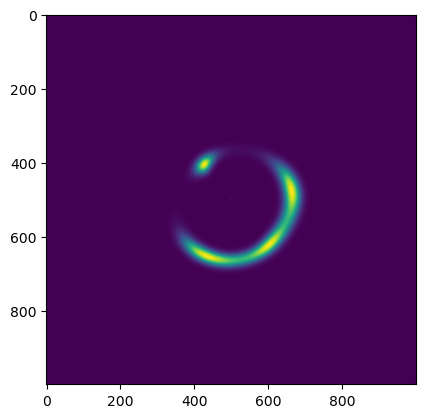

tensor(5.9545e-06, device='cuda:0')
tensor(5.9545e-06, device='cuda:0')
tensor(5.9545e-06, device='cuda:0')
tensor(5.9545e-06, device='cuda:0')


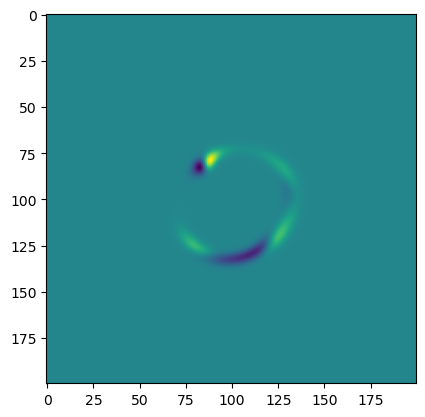

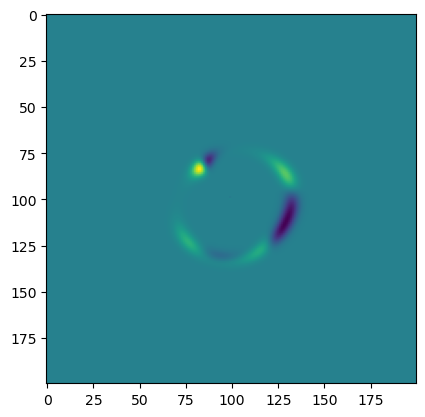

tensor(5.9664e-06, device='cuda:0')
tensor(5.9426e-06, device='cuda:0')
vel_disp


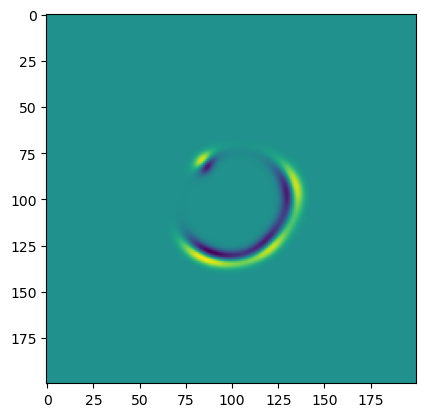

tensor(5.9545e-06, device='cuda:0')
tensor(5.9545e-06, device='cuda:0')
slope


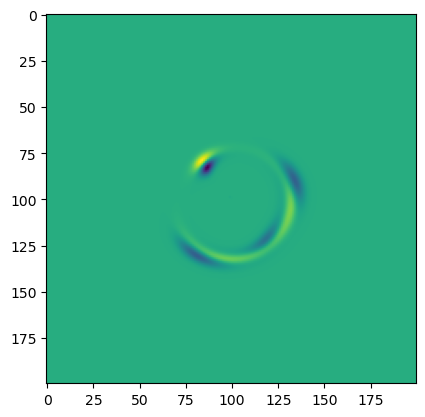

tensor(5.9545e-06, device='cuda:0')
tensor(5.9545e-06, device='cuda:0')
orient


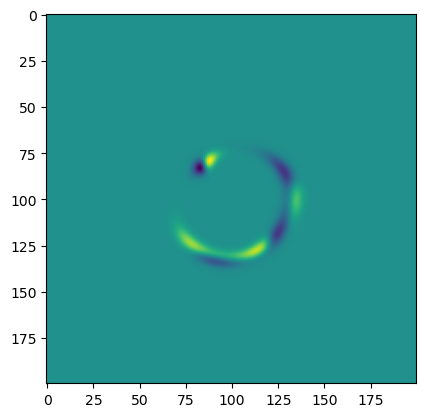

tensor(5.9545e-06, device='cuda:0')
tensor(5.9545e-06, device='cuda:0')
q


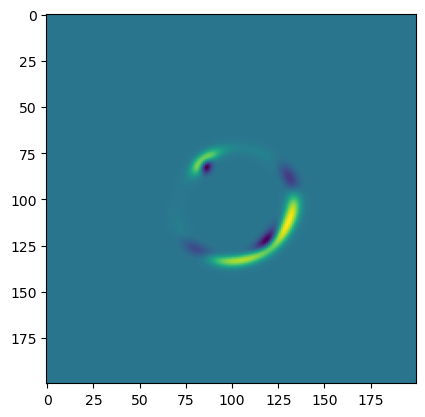

In [9]:
from lensing_system.sources import GaussianBlob as GaussianBlobNonBatched
import copy


image_grid=_grid_lens(8.0, 1000, device="cuda")


#===============start by making the base image without the sub============================
main_lens_dict_no_sub=recursive_to_tensor(main_lens_dict, device="cuda")


#1: compute the deflection of the main lens
main_lens_model     = LensModelNonBatched(
                        main_lens_dict_no_sub["lens_model"], 
                        precomp_dict=main_lens_dict_no_sub["precomputed"], 
                        device='cuda'
                    )


import pprint
source_model= GaussianBlobNonBatched(
    main_lens_dict_no_sub["source_model"]["params"], 
    precomp_dict=main_lens_dict_no_sub["precomputed"], 
    device='cuda'
)

source_redshift = main_lens_dict_no_sub["source_model"]["params"]["redshift"]
deflection_no_sub = main_lens_model(image_grid, source_redshift).unsqueeze(0)
source_grid=deflection_no_sub
base_image=source_model(source_grid)

import matplotlib.pyplot as plt

plt.imshow(base_image.squeeze(0).detach().cpu().numpy())
plt.show()




# HERE COMPUTED THE BASE MATRIXES FOR THE PARAMETERS VARIATIONS:
# Both of the lens and of the source,  and precomputed params

lens_param_variations=[]

lens_params=main_lens_dict_no_sub["lens_model"]["mass_components"][0]["params"]
#pprint.pprint(lens_params)


for param, param_value in lens_params.items():
    if param=="redshift":
        continue
    
    lens_dict_temp=copy.deepcopy(main_lens_dict_no_sub)
    
    
    if param=="pos":
        lens_dict_temp_high_x=copy.deepcopy(main_lens_dict_no_sub)
        lens_dict_temp_low_x=copy.deepcopy(main_lens_dict_no_sub)
        lens_dict_temp_high_y=copy.deepcopy(main_lens_dict_no_sub)
        lens_dict_temp_low_y=copy.deepcopy(main_lens_dict_no_sub)
        
        lens_dict_temp_high_x["lens_model"]["mass_components"][0]["params"][param][0]=lens_dict_temp["lens_model"]["mass_components"][0]["params"][param][0]+1e-7
        lens_dict_temp_low_x["lens_model"]["mass_components"][0]["params"][param][0]=lens_dict_temp["lens_model"]["mass_components"][0]["params"][param][0]-1e-7
        
        lens_dict_temp_high_y["lens_model"]["mass_components"][0]["params"][param][1]=lens_dict_temp["lens_model"]["mass_components"][0]["params"][param][1]+1e-7
        lens_dict_temp_low_y["lens_model"]["mass_components"][0]["params"][param][1]=lens_dict_temp["lens_model"]["mass_components"][0]["params"][param][1]-1e-7





        main_lens_model_high_x   = LensModelNonBatched(
                            lens_dict_temp_high_x["lens_model"], 
                            precomp_dict=main_lens_dict_no_sub["precomputed"], 
                            device='cuda'
                        )

        main_lens_model_low_x   = LensModelNonBatched(
                            lens_dict_temp_low_x["lens_model"], 
                            precomp_dict=main_lens_dict_no_sub["precomputed"], 
                            device='cuda'
                        )
        
        main_lens_model_high_y   = LensModelNonBatched(
                            lens_dict_temp_high_y["lens_model"], 
                            precomp_dict=main_lens_dict_no_sub["precomputed"], 
                            device='cuda'
                        )

        main_lens_model_low_y   = LensModelNonBatched(
                            lens_dict_temp_low_y["lens_model"], 
                            precomp_dict=main_lens_dict_no_sub["precomputed"], 
                            device='cuda'
                        )

        source_model= GaussianBlobNonBatched(
            main_lens_dict_no_sub["source_model"]["params"], 
            precomp_dict=main_lens_dict_no_sub["precomputed"], 
            device='cuda'
        )


        deflection_high_x = main_lens_model_high_x(image_grid, source_redshift).unsqueeze(0)
        deflection_low_x = main_lens_model_low_x(image_grid, source_redshift).unsqueeze(0)
        
        deflection_high_y = main_lens_model_high_y(image_grid, source_redshift).unsqueeze(0)
        deflection_low_y = main_lens_model_low_y(image_grid, source_redshift).unsqueeze(0)


        source_grid_high_x=deflection_high_x
        image_high_x=source_model(source_grid_high_x)


        source_grid_low_x=deflection_low_x
        image_low_x=source_model(source_grid_low_x)
        
        source_grid_high_y=deflection_high_y
        image_high_y=source_model(source_grid_high_y)


        source_grid_low_y=deflection_low_y
        image_low_y=source_model(source_grid_low_y)

        variation_x=image_high_x-image_low_x
        variation_y=image_high_y-image_low_y

        variation_x=F.avg_pool2d(variation_x, kernel_size=5, stride=5)
        variation_y=F.avg_pool2d(variation_y, kernel_size=5, stride=5)


        lens_param_variations.append(variation_x.squeeze(0).detach().cpu().numpy())
        lens_param_variations.append(variation_y.squeeze(0).detach().cpu().numpy())

        
        
        plt.imshow(variation_x.squeeze(0).detach().cpu().numpy())
        plt.show()
        plt.imshow(variation_y.squeeze(0).detach().cpu().numpy())
        plt.show()
        
        
        
        
    else:
        lens_dict_temp_high=copy.deepcopy(main_lens_dict_no_sub)
        lens_dict_temp_low=copy.deepcopy(main_lens_dict_no_sub)
        
        lens_dict_temp_high["lens_model"]["mass_components"][0]["params"][param]=lens_dict_temp["lens_model"]["mass_components"][0]["params"][param]*1.001
        lens_dict_temp_low["lens_model"]["mass_components"][0]["params"][param]=lens_dict_temp["lens_model"]["mass_components"][0]["params"][param]*0.999






        main_lens_model_high   = LensModelNonBatched(
                            lens_dict_temp_high["lens_model"], 
                            precomp_dict=main_lens_dict_no_sub["precomputed"], 
                            device='cuda'
                        )

        main_lens_model_low   = LensModelNonBatched(
                            lens_dict_temp_low["lens_model"], 
                            precomp_dict=main_lens_dict_no_sub["precomputed"], 
                            device='cuda'
                        )

        source_model= GaussianBlobNonBatched(
            main_lens_dict_no_sub["source_model"]["params"], 
            precomp_dict=main_lens_dict_no_sub["precomputed"], 
            device='cuda'
        )


        deflection_high = main_lens_model_high(image_grid, source_redshift).unsqueeze(0)
        deflection_low = main_lens_model_low(image_grid, source_redshift).unsqueeze(0)

        source_grid_high=deflection_high
        image_high=source_model(source_grid_high)


        source_grid_low=deflection_low
        image_low=source_model(source_grid_low)

        variation=image_high-image_low

        print(param)
        
        variation=F.avg_pool2d(variation, kernel_size=5, stride=5)

        lens_param_variations.append(variation.squeeze(0).detach().cpu().numpy())

        plt.imshow(variation.squeeze(0).detach().cpu().numpy())
        plt.show()


    











            

tensor(5.9545e-06, device='cuda:0')
tensor(5.9545e-06, device='cuda:0')
D_l


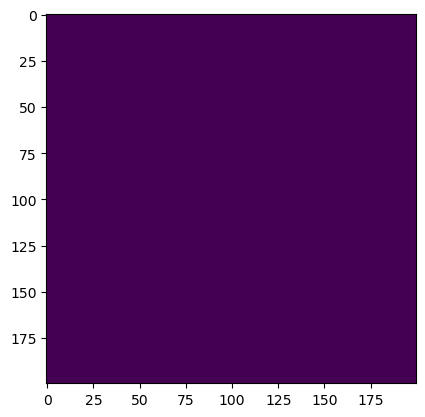

tensor(5.9486e-06, device='cuda:0')
tensor(5.9605e-06, device='cuda:0')
D_s


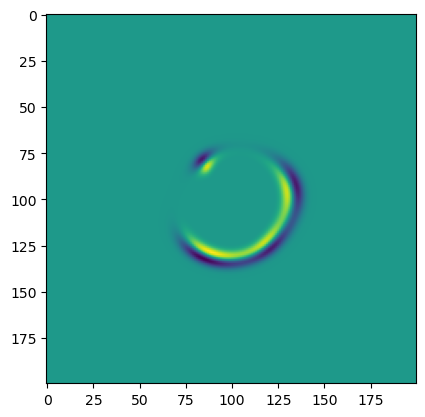

tensor(5.9605e-06, device='cuda:0')
tensor(5.9486e-06, device='cuda:0')
D_ls


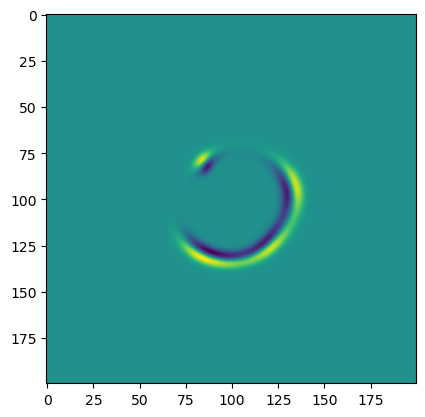

In [10]:
# Now lets make variations of the precomputed parameters, i.e. geometry of the system
# Here in a stupid way:
'''
    I SHOULD NOT VARY INDEPENDENTLY DS DL AND DLS!!!!!!!!!!!!!!!!!!!

'''

precomp_params=main_lens_dict_no_sub["precomputed"]
#pprint.pprint(lens_params)


for param, param_value in precomp_params.items():
    if param=="Theta_E":
        continue
    
    precomp_high=copy.deepcopy(precomp_params)
    precomp_low=copy.deepcopy(precomp_params)

    precomp_high[param]=precomp_high[param]*1.001
    precomp_low[param]=precomp_low[param]*0.999




    main_lens_model_high   = LensModelNonBatched(
                        main_lens_dict_no_sub["lens_model"], 
                        precomp_dict=precomp_high, 
                        device='cuda'
                    )

    main_lens_model_low   = LensModelNonBatched(
                        main_lens_dict_no_sub["lens_model"], 
                        precomp_dict=precomp_low, 
                        device='cuda'
                    )

    source_model_high= GaussianBlobNonBatched(
        main_lens_dict_no_sub["source_model"]["params"], 
        precomp_dict=precomp_high, 
        device='cuda'
    )

    
    source_model_low= GaussianBlobNonBatched(
        main_lens_dict_no_sub["source_model"]["params"], 
        precomp_dict=precomp_low, 
        device='cuda'
    )


    deflection_high = main_lens_model_high(image_grid, source_redshift).unsqueeze(0)
    deflection_low = main_lens_model_low(image_grid, source_redshift).unsqueeze(0)

    source_grid_high=deflection_high
    image_high=source_model_high(source_grid_high)


    source_grid_low=deflection_low
    image_low=source_model_low(source_grid_low)

    variation=image_high-image_low

    print(param)
    variation=F.avg_pool2d(variation, kernel_size=5, stride=5)

    lens_param_variations.append(variation.squeeze(0).detach().cpu().numpy())

    plt.imshow(variation.squeeze(0).detach().cpu().numpy())
    plt.show()


    








tensor(5.9545e-06, device='cuda:0')
I


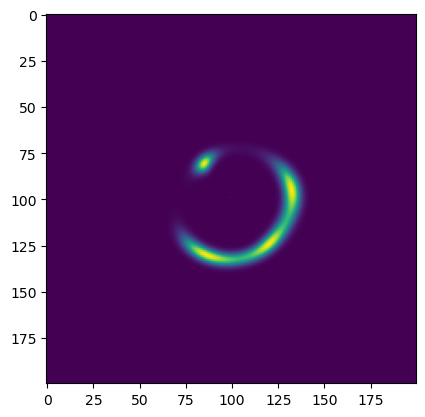

tensor(5.9545e-06, device='cuda:0')
position_rad


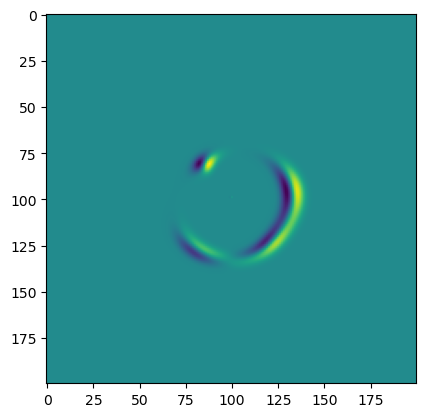

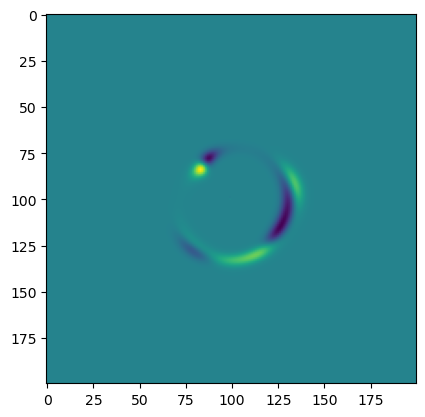

tensor(5.9545e-06, device='cuda:0')
orient_rad


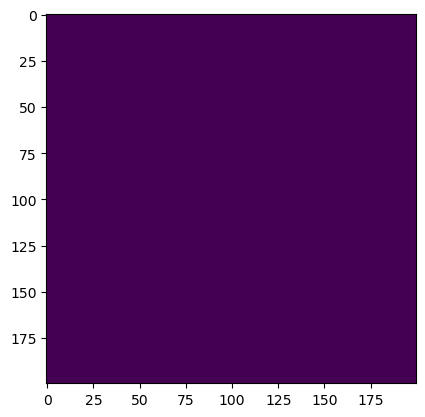

tensor(5.9545e-06, device='cuda:0')
q


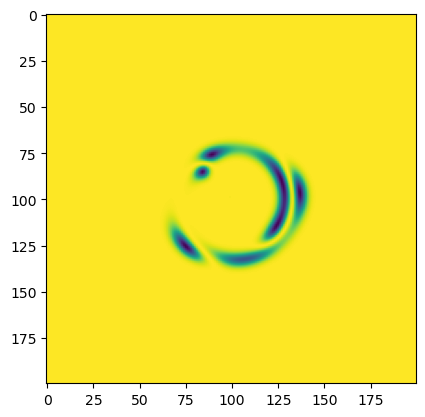

tensor(5.9545e-06, device='cuda:0')
std_kpc


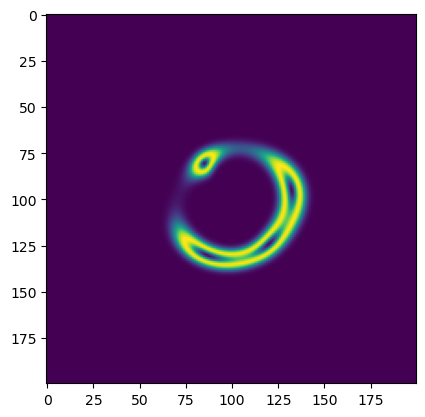

In [11]:
# and finally the source parameters



source_params=main_lens_dict_no_sub["source_model"]["params"]
#pprint.pprint(lens_params)


for param, param_value in source_params.items():
    if param=="redshift": #redshift is passed trough precomp
        continue
    
    source_dict_temp=copy.deepcopy(main_lens_dict_no_sub["source_model"])
    
    
    if param=="position_rad":
        source_dict_temp_high_x=copy.deepcopy(source_dict_temp)
        source_dict_temp_low_x=copy.deepcopy(source_dict_temp)
        source_dict_temp_high_y=copy.deepcopy(source_dict_temp)
        source_dict_temp_low_y=copy.deepcopy(source_dict_temp)
        
        source_dict_temp_high_x["params"][param][0]=source_dict_temp["params"][param][0]+1e-7
        source_dict_temp_low_x["params"][param][0]=source_dict_temp["params"][param][0]-1e-7
        
        source_dict_temp_high_y["params"][param][1]=source_dict_temp["params"][param][1]+1e-7
        source_dict_temp_low_y["params"][param][1]=source_dict_temp["params"][param][1]-1e-7





        main_lens_model  = LensModelNonBatched(
                            main_lens_dict_no_sub["lens_model"], 
                            precomp_dict=main_lens_dict_no_sub["precomputed"], 
                            device='cuda'
                        )


        source_model_high_x= GaussianBlobNonBatched(
            source_dict_temp_high_x["params"], 
            precomp_dict=main_lens_dict_no_sub["precomputed"], 
            device='cuda'
        )
        
        source_model_low_x= GaussianBlobNonBatched(
            source_dict_temp_low_x["params"], 
            precomp_dict=main_lens_dict_no_sub["precomputed"], 
            device='cuda'
        )
        
        source_model_high_y= GaussianBlobNonBatched(
            source_dict_temp_high_y["params"], 
            precomp_dict=main_lens_dict_no_sub["precomputed"], 
            device='cuda'
        )
        
        source_model_low_y= GaussianBlobNonBatched(
            source_dict_temp_low_y["params"], 
            precomp_dict=main_lens_dict_no_sub["precomputed"], 
            device='cuda'
        )


        deflection = main_lens_model(image_grid, source_redshift).unsqueeze(0)

        source_grid=deflection
        
        image_high_x=source_model_high_x(source_grid_high_x)
        image_low_x=source_model_low_x(source_grid_low_x)
        image_high_y=source_model_high_x(source_grid_high_y)
        image_low_y=source_model_low_x(source_grid_low_y)
        

        variation_x=image_high_x-image_low_x
        variation_y=image_high_y-image_low_y


        
        variation_x=F.avg_pool2d(variation_x, kernel_size=5, stride=5)
        variation_y=F.avg_pool2d(variation_y, kernel_size=5, stride=5)

        lens_param_variations.append(variation_x.squeeze(0).detach().cpu().numpy())
        lens_param_variations.append(variation_y.squeeze(0).detach().cpu().numpy())

        
        print(param)
        plt.imshow(variation_x.squeeze(0).detach().cpu().numpy())
        plt.show()
        plt.imshow(variation_y.squeeze(0).detach().cpu().numpy())
        plt.show()
        
        
        
        
    else:
        source_dict_temp_high=copy.deepcopy(source_dict_temp)
        source_dict_temp_low=copy.deepcopy(source_dict_temp)
  
        source_dict_temp_high["params"][param]=source_dict_temp["params"][param]*1.001
        source_dict_temp_low["params"][param]=source_dict_temp["params"][param]*0.999
        
   


        #pprint.pprint(source_dict_temp_high)

        main_lens_model  = LensModelNonBatched(
                            main_lens_dict_no_sub["lens_model"], 
                            precomp_dict=main_lens_dict_no_sub["precomputed"], 
                            device='cuda'
                        )


        source_model_high= GaussianBlobNonBatched(
            source_dict_temp_high["params"], 
            precomp_dict=main_lens_dict_no_sub["precomputed"], 
            device='cuda'
        )
        
        source_model_low= GaussianBlobNonBatched(
            source_dict_temp_low["params"], 
            precomp_dict=main_lens_dict_no_sub["precomputed"], 
            device='cuda'
        )
        
   

        deflection = main_lens_model(image_grid, source_redshift).unsqueeze(0)

        source_grid=deflection
        
        image_high=source_model_high(source_grid)
        image_low=source_model_low(source_grid)
       
        

        variation=image_high-image_low
        
        variation=F.avg_pool2d(variation, kernel_size=5, stride=5)


        lens_param_variations.append(variation.squeeze(0).detach().cpu().numpy())

        
        print(param)
        plt.imshow(variation.squeeze(0).detach().cpu().numpy())
        plt.show()
     
    





# some mistakes!! like the perturbation of the angles has no meaning in beeing percentual


## Anyway, now lets normalize the results, and kill those that are all zeros



In [12]:
lens_param_variations=np.array(lens_param_variations)

In [13]:
lens_param_variations_tensor=torch.tensor(lens_param_variations)

In [14]:
print(lens_param_variations.shape)

(15, 200, 200)


tensor(5.9545e-06, device='cuda:0')
torch.Size([200, 200])


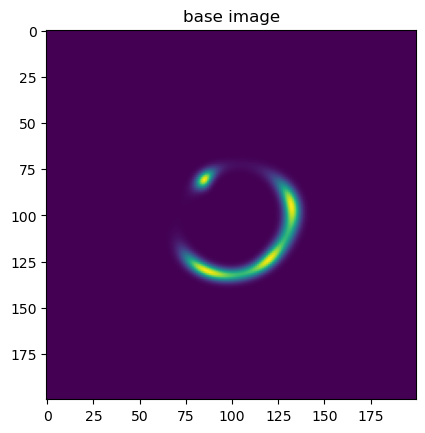

  0%|          | 0/9 [00:00<?, ?it/s]

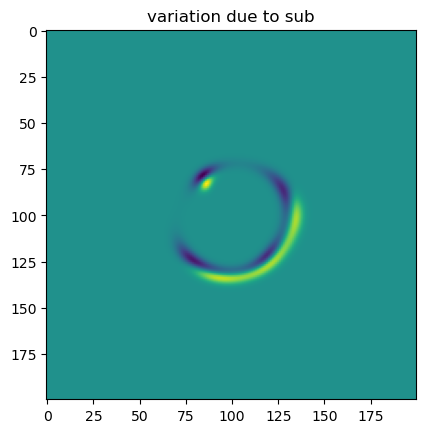

 11%|█         | 1/9 [00:00<00:01,  5.19it/s]

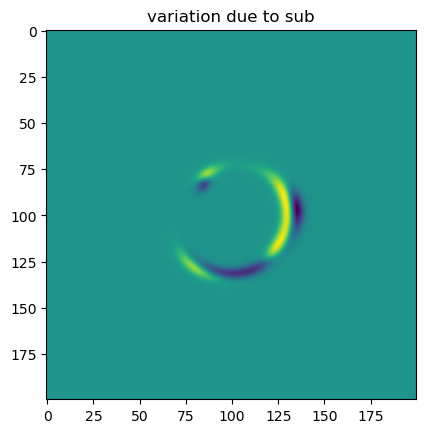

 22%|██▏       | 2/9 [00:00<00:01,  6.13it/s]

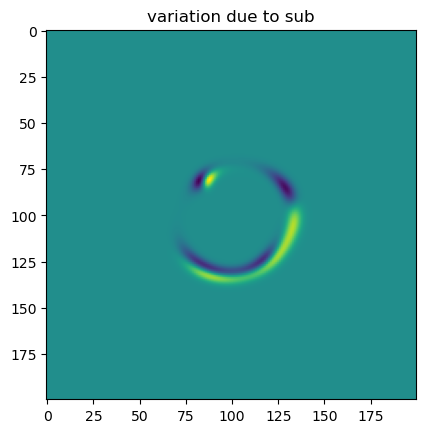

 33%|███▎      | 3/9 [00:00<00:00,  6.49it/s]

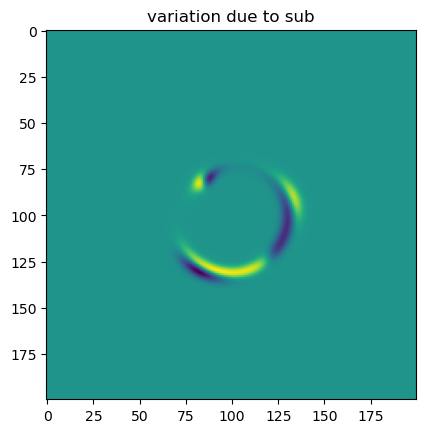

 44%|████▍     | 4/9 [00:00<00:00,  6.72it/s]

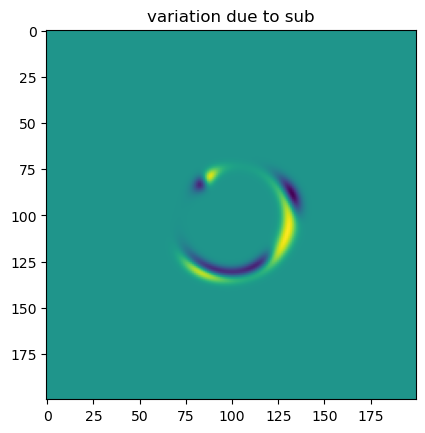

 56%|█████▌    | 5/9 [00:00<00:00,  6.86it/s]

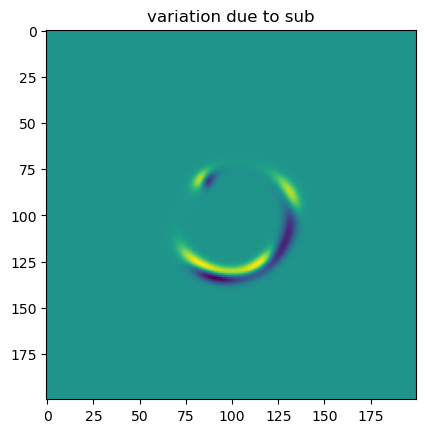

 67%|██████▋   | 6/9 [00:00<00:00,  6.95it/s]

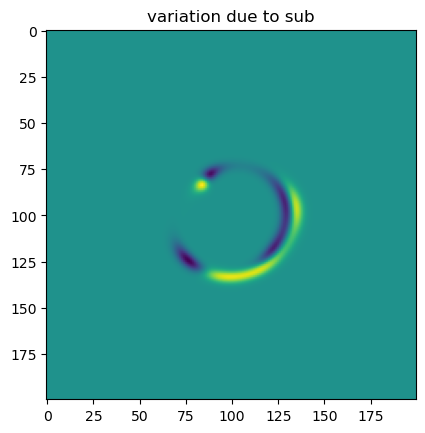

 78%|███████▊  | 7/9 [00:01<00:00,  7.01it/s]

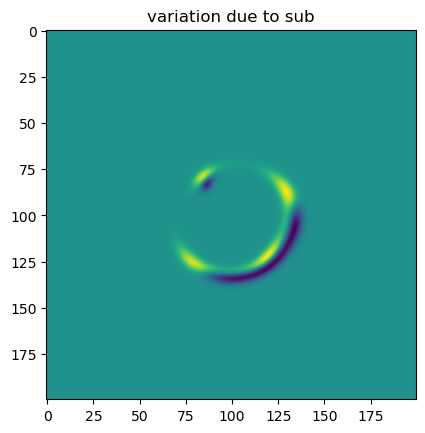

 89%|████████▉ | 8/9 [00:01<00:00,  7.06it/s]

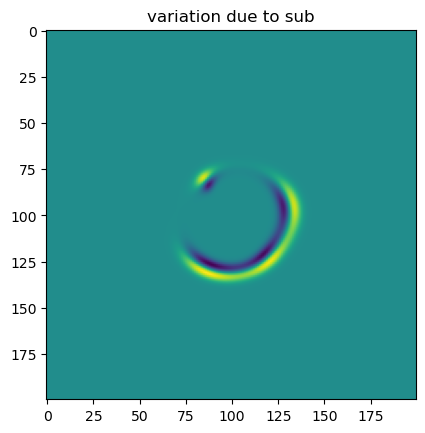

100%|██████████| 9/9 [00:01<00:00,  6.81it/s]


In [15]:
# NOW COMPUTE THE MATRIX OF VARIATION DUE TO THE SUB
#eval_grid=_grid_lens(10.0, 80, device="cuda")
eval_grid=_grid_lens(8.0, 3, device="cuda")
image_grid=_grid_lens(8.0, 200, device="cuda")

class SensMapMaker_from_projections:
    def __init__(
        self,
        main_lens_dict=main_lens_dict,
        substructure_dict=sub_dict,
        sub_key_changed="mass_max",
        values_key = 10**torch.linspace(7.,12., 14),
        evaluation_grid=eval_grid,
        image_grid=image_grid,
        batch_size=14,
        variations_tensor=lens_param_variations_tensor
    ):
        self.aux_counter_temp_remove=0
        self.image_grid=image_grid
        self.evaluation_grid=evaluation_grid
        self.batch_size=batch_size
        
        main_lens_dict=recursive_to_tensor(main_lens_dict, device="cuda")
        self.precomp_raw=main_lens_dict["precomputed"] #raw because it will have to be converted to a specific format
        self.source_raw=main_lens_dict["source_model"]
        #1: compute the deflection of the main lens
        main_lens_model = LensModelNonBatched(
            main_lens_dict["lens_model"], 
            precomp_dict=main_lens_dict["precomputed"], 
            device='cuda')

        self.source_redshift = main_lens_dict["source_model"]["params"]["redshift"]
        self.base_deflection = main_lens_model(image_grid, self.source_redshift).unsqueeze(0).repeat(batch_size, 1, 1, 1)

        #2: build the systems made of only one sub properly,
        # : we can't built them all toghether with the current lens class.
        # : but I can prepare the batches of initializations, as well as the sub class
        self.sub_raw=sub_dict
        self.set_sub_params_matrix(evaluation_grid, sub_key_changed, values_key)
        #3: build the source properly: since the source is always the same, 
        #   we could keep only one object, with the params and precomp of the fixed size
        #   of the calculation batch.

        source_data=self.get_source_config(batch_size)
        source_precomp=self.get_expanded_precomp(batch_size)
        
        self.source_model=SourceModel(source_data, source_precomp)

        self.base_image=self.source_model(self.base_deflection)[0]
        
        print(self.base_image.shape)
        import matplotlib.pyplot as plt
        
        plt.imshow(self.base_image.detach().cpu())
        plt.title("base image")
        plt.show()
        
        self.variations_tensor=self.process_variations(variations_tensor)

            
        self.score_matrix=self.get_score_matrix() # two dimensions: absolute variation of the image and matching with parameter_variations
        
        
    def process_variations(self, variations):
        """
            Frobenius-normalize and discard zero images
            
            In the second code, create orthonormal basis
        """
#         # compute per-image Frobenius norms, shape (15,)
#         norms = variations.norm(p='fro', dim=(1,2))  

#         # decide a small ε so that "zero images" are those with norm <= ε
#         eps = 1e-12
#         mask = norms > eps           # boolean mask of shape (15,)

#         # select only the non-zero images
#         variations_nonzero = variations[mask]    # shape (N_nonzero, 200, 200)
#         norms_nonzero = norms[mask]  # shape (N_nonzero,)

#         # normalize those to unit norm
#         variations_normed = (variations_nonzero / norms_nonzero.view(-1,1,1)).to("cuda")
        
#         print(variations_normed.shape)
#         return variations_normed
    
        V=variations.to("cuda")
        eps=1e-12
    
        N, H, W = V.shape
        assert H == W, "Images must be square (H == W), but got H={}, W={}".format(H, W)

        # flatten each image to a vector of length H*W
        flat = V.view(N, -1)        # shape (N, H*W)

        # optionally drop any zero‐norm images first
        norms = flat.norm(dim=1)
        mask  = norms > eps
        if mask.sum() < 1:
            raise ValueError("All input images are (near) zero; nothing to orthogonalize.")
        flat_good = flat[mask]      # shape (M, H*W) with M <= N

        # form matrix A of shape (H*W, M) whose columns are the flattened images
        A = flat_good.T             # (H*W, M)

        # reduced QR: Q has shape (H*W, M), with orthonormal columns
        Q, R = torch.linalg.qr(A, mode='reduced')

        # reshape back to image form: we only return the M non-zero orthonormal images
        orth_images = Q.T.view(-1, H, W).to("cuda")  # shape (M, H, W)
        

        return orth_images

    def set_sub_params_matrix(self, evaluation_grid, sub_key_changed, values_key):
        # thi is a matrix of this shape:
        # if n_p is the number of params of the sub, and n_t the nubmer of values tried
        # [n_p, n_t, shape_eval_grid]
        H, W = evaluation_grid.shape[:2]

        self.n_values=n_values=torch.as_tensor(values_key).shape[0]
        sub_param_map={
            'NFW': ['pos_x', 'pos_y','mass_max','r_max_kpc','redshift'],
        }

        sub_type=self.sub_raw["type"]
        sub_params=self.sub_raw["params"]

        if sub_type not in sub_param_map:
            raise NotImplemented

        if sub_type=='NFW':
            init_tensor=torch.tensor([
                sub_params['pos'][0],
                sub_params['pos'][1],
                sub_params['mass_max'],
                sub_params['r_max_kpc'],
                sub_params['redshift'],

            ], device="cuda")
            
            self.n_params=5
            self.sub_type='NFW'
            params_matrix=torch.empty((self.n_params, n_values, evaluation_grid.shape[0], evaluation_grid.shape[1]))
            params_matrix[0, :, :, :]=evaluation_grid[:,:, 0]
            params_matrix[1, :, :, :]=evaluation_grid[:,:, 1]
            params_matrix[2:] = init_tensor[2:, None, None, None].expand(-1, n_values, H, W)
            #now_fill the rest of the matrix
            
            if sub_key_changed=="mass_max":
                # move to the same device/dtype as your params_matrix
                vals = torch.as_tensor(values_key, device=params_matrix.device, dtype=params_matrix.dtype)
                
                value_r_max=torch.as_tensor(get_r_max_from_M_max(values_key), device=params_matrix.device, dtype=params_matrix.dtype)
                # reshape to (n_values, 1, 1)
                vals = vals.view(n_values, 1, 1)
                value_r_max= value_r_max.view(n_values, 1, 1)

                # Option B: explicitly expand to (n_values, H, W)
                vals_expanded = vals.expand(n_values, H, W)
                value_r_max_expanded=value_r_max.expand(n_values, H, W)
                params_matrix[2] = vals_expanded
                params_matrix[3] = value_r_max_expanded

            
            else:
                raise NotImplemented
                
            self.params_matrix=params_matrix


    def get_score_matrix(self):
        
        #initialize the logits matrix
        all_scores=[]
        bs=self.batch_size
        
        flat = self.params_matrix.permute(1, 2, 3, 0)  
        flat = flat.reshape(-1, self.n_params)  
        shared_precomp=self.get_expanded_precomp(bs)
        
        H, W = self.evaluation_grid.shape[:2]
        
        tot_im_to_comp=flat.shape[0]
        
        #Noise
        
#         sky_level=0.05
#         kernel_size=5
#         kernel_sigma=1.0
#         gain=500
        
#         gauss_kernel = GaussKernel(kernel_size, sigma=kernel_sigma, device="cuda").get_kernel()
#         self.psf_and_poisson_noise = NoiseApplicator(apply_poisson=True,
#                                                     sky_level=sky_level,
#                                                     gain=gain,
#                                                     psf=gauss_kernel,
#                                                     device="cuda")
        
        
        #strategy with last batch:just pad and slice away

        for i in tqdm.tqdm(range(0, flat.shape[0], bs)):
            is_last_batch=i+bs> tot_im_to_comp
            if is_last_batch:
                batch_params = flat[i:i+bs]   
                cur_bs = batch_params.size(0)
                last_row = batch_params[-1:]
                padding  = last_row.expand(bs - cur_bs, -1)
                batch_params = torch.cat([batch_params, padding], dim=0)
            else:
                batch_params = flat[i:i+bs]      

            sub_init=self.get_sub_init(batch_params, self.sub_type)
            sub_model=LensModel(
                bs,
                sub_init,
                shared_precomp
            )

            sub_deflection = sub_model.deflection_field(self.image_grid)
            source_grid=self.base_deflection+sub_deflection
            images=self.source_model(source_grid).unsqueeze(1)





            scores = self.get_scores(images)        # -> [<=bs, 2]
            
            
            if is_last_batch:
                all_scores.append(scores[:cur_bs])

            else:
                all_scores.append(scores)

        all_scores = torch.cat(all_scores, dim=0)  # [n_values*H*W, 2]

        
        score_matrix = all_scores.view(self.n_values, H, W, 2)
        self.score_matrix = score_matrix.permute(3, 0, 1, 2)
        return score_matrix
        
    def get_scores(self, image_batch):
        images=image_batch.squeeze(1)
        #first score is a "norm of the image difference
        variation_due_to_sub=self.base_image-images
        
        
        self.aux_counter_temp_remove+=1
        
    
        plt.imshow(variation_due_to_sub[0].detach().cpu())
        plt.title("variation due to sub")
        plt.show()

        #mask out non-observable variations
        
        
        
        norms=variation_due_to_sub.norm(p='fro', dim=(1,2), keepdim=True)
        
        first_score = norms.squeeze(1).squeeze(1)
        
        normalized_variation_sub=variation_due_to_sub/norms
        
        coeffs = torch.tensordot(normalized_variation_sub, self.variations_tensor, dims=([1,2], [1,2]))
        #coeffs=torch.norm(coeffs,p=2, dim=1)
        coeffs=coeffs.abs().sum(dim=1)
        
        scores=torch.stack((first_score, coeffs), dim=1)
        
        return scores
        
        
    def get_sub_init(self, parameters_batch, sub_type):
        sub_param_map={
            'NFW': ['pos_x', 'pos_y','mass_max','r_max_kpc','redshift'],
        }
        sub_init= {
            sub_type:{
                'sys_idx':   torch.arange(0, parameters_batch.shape[0], device="cuda"),
                'params':    parameters_batch,
                'param_map': sub_param_map[sub_type]
            }
        }
        return sub_init

    

            
    def get_expanded_precomp(self, n_samples):
        precomp_map = ['D_l', 'D_s', 'D_ls', 'Theta_E']
        params=torch.tensor([[
             self.precomp_raw['D_l'], 
             self.precomp_raw['D_s'], 
             self.precomp_raw['D_ls'], 
             self.precomp_raw['Theta_E'] 
        ]], device="cuda")

        precomp_processed = {
            'sys_idx':   torch.arange(0, n_samples, device="cuda"),
            'params': params.repeat(n_samples, 1),
            'param_map': precomp_map
        }

        return precomp_processed


    def get_source_config(self, n_samples):
        source_param_map={
            'Gaussian_blob': ['position_rad_x', 'position_rad_y', 'I' ,'orient_rad','q','std_kpc','redshift']
        }

        source_type=self.source_raw["type"]
        source_params=self.source_raw["params"]

        if source_type not in source_param_map:
            raise NotImplemented

        if source_type=='Gaussian_blob':
            init_tensor=torch.tensor([[
                source_params['position_rad'][0],
                source_params['position_rad'][1],
                source_params['I'],
                source_params['orient_rad'],
                source_params['q'],
                source_params['std_kpc'],
                source_params['redshift'],

            ]], device="cuda")

        source_init={
            source_type: 0
        }
        source_init[source_type] = {
            'sys_idx':   torch.arange(0, n_samples, device="cuda"),
            'params':    init_tensor.repeat(n_samples, 1),
            'param_map': source_param_map[source_type]
        }
        return source_init
    def logits_mat_to_detect_thres(self, confidence):
        pass

b=SensMapMaker_from_projections()

tensor(5.9545e-06, device='cuda:0')
torch.Size([200, 200])


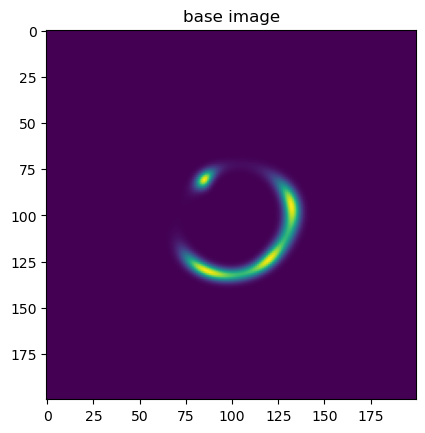

100%|██████████| 350/350 [00:03<00:00, 94.87it/s]


In [19]:
# NOW COMPUTE THE MATRIX OF VARIATION DUE TO THE SUB
eval_grid=_grid_lens(10.0, 80, device="cuda")

class SensMapMaker_from_projections:
    def __init__(
        self,
        main_lens_dict=main_lens_dict,
        substructure_dict=sub_dict,
        sub_key_changed="mass_max",
        values_key = 10**torch.linspace(7.,11., 14),
        evaluation_grid=eval_grid,
        image_grid=image_grid,
        batch_size=256,
        variations_tensor=lens_param_variations_tensor
    ):
        self.aux_counter_temp_remove=0
        self.image_grid=image_grid
        self.evaluation_grid=evaluation_grid
        self.batch_size=batch_size
        
        main_lens_dict=recursive_to_tensor(main_lens_dict, device="cuda")
        self.precomp_raw=main_lens_dict["precomputed"] #raw because it will have to be converted to a specific format
        self.source_raw=main_lens_dict["source_model"]
        #1: compute the deflection of the main lens
        main_lens_model = LensModelNonBatched(
            main_lens_dict["lens_model"], 
            precomp_dict=main_lens_dict["precomputed"], 
            device='cuda')

        self.source_redshift = main_lens_dict["source_model"]["params"]["redshift"]
        self.base_deflection = main_lens_model(image_grid, self.source_redshift).unsqueeze(0).repeat(batch_size, 1, 1, 1)

        #2: build the systems made of only one sub properly,
        # : we can't built them all toghether with the current lens class.
        # : but I can prepare the batches of initializations, as well as the sub class
        self.sub_raw=sub_dict
        self.set_sub_params_matrix(evaluation_grid, sub_key_changed, values_key)
        #3: build the source properly: since the source is always the same, 
        #   we could keep only one object, with the params and precomp of the fixed size
        #   of the calculation batch.

        source_data=self.get_source_config(batch_size)
        source_precomp=self.get_expanded_precomp(batch_size)
        
        self.source_model=SourceModel(source_data, source_precomp)

        self.base_image=self.source_model(self.base_deflection)[0]
        
        
        sky_background = 0.01  # or whatever your model assumes
        self.sigma = torch.sqrt(self.base_image + sky_background)  # shape (H, W)


        print(self.base_image.shape)
        import matplotlib.pyplot as plt
        
        plt.imshow(self.base_image.detach().cpu())
        plt.title("base image")
        plt.show()
        
        self.variations_tensor=self.process_variations(variations_tensor)

            
        self.score_matrix=self.get_score_matrix() # two dimensions: absolute variation of the image and matching with parameter_variations
        
        
    def process_variations(self, variations):
        """
            Frobenius-normalize and discard zero images
            
            In the second code, create orthonormal basis
        """
#         # compute per-image Frobenius norms, shape (15,)
#         norms = variations.norm(p='fro', dim=(1,2))  

#         # decide a small ε so that "zero images" are those with norm <= ε
#         eps = 1e-12
#         mask = norms > eps           # boolean mask of shape (15,)

#         # select only the non-zero images
#         variations_nonzero = variations[mask]    # shape (N_nonzero, 200, 200)
#         norms_nonzero = norms[mask]  # shape (N_nonzero,)

#         # normalize those to unit norm
#         variations_normed = (variations_nonzero / norms_nonzero.view(-1,1,1)).to("cuda")
        
#         print(variations_normed.shape)
#         return variations_normed
    
        V=variations.to("cuda")
        eps=1e-14
    
        N, H, W = V.shape
        assert H == W, "Images must be square (H == W), but got H={}, W={}".format(H, W)

        # flatten each image to a vector of length H*W
        flat = V.view(N, -1)        # shape (N, H*W)

        # optionally drop any zero‐norm images first
        norms = flat.norm(dim=1)
        mask  = norms > eps
        if mask.sum() < 1:
            raise ValueError("All input images are (near) zero; nothing to orthogonalize.")
        flat_good = flat[mask]      # shape (M, H*W) with M <= N

        # form matrix A of shape (H*W, M) whose columns are the flattened images
        A = flat_good.T             # (H*W, M)

        # reduced QR: Q has shape (H*W, M), with orthonormal columns
        Q, R = torch.linalg.qr(A, mode='reduced')

        # reshape back to image form: we only return the M non-zero orthonormal images
        orth_images = Q.T.view(-1, H, W).to("cuda")  # shape (M, H, W)
        

        return orth_images

    def set_sub_params_matrix(self, evaluation_grid, sub_key_changed, values_key):
        # thi is a matrix of this shape:
        # if n_p is the number of params of the sub, and n_t the nubmer of values tried
        # [n_p, n_t, shape_eval_grid]
        H, W = evaluation_grid.shape[:2]

        self.n_values=n_values=torch.as_tensor(values_key).shape[0]
        sub_param_map={
            'NFW': ['pos_x', 'pos_y','mass_max','r_max_kpc','redshift'],
        }

        sub_type=self.sub_raw["type"]
        sub_params=self.sub_raw["params"]

        if sub_type not in sub_param_map:
            raise NotImplemented

        if sub_type=='NFW':
            init_tensor=torch.tensor([
                sub_params['pos'][0],
                sub_params['pos'][1],
                sub_params['mass_max'],
                sub_params['r_max_kpc'],
                sub_params['redshift'],

            ], device="cuda")
            
            self.n_params=5
            self.sub_type='NFW'
            params_matrix=torch.empty((self.n_params, n_values, evaluation_grid.shape[0], evaluation_grid.shape[1]))
            params_matrix[0, :, :, :]=evaluation_grid[:,:, 0]
            params_matrix[1, :, :, :]=evaluation_grid[:,:, 1]
            params_matrix[2:] = init_tensor[2:, None, None, None].expand(-1, n_values, H, W)
            #now_fill the rest of the matrix
            
            if sub_key_changed=="mass_max":
                # move to the same device/dtype as your params_matrix
                vals = torch.as_tensor(values_key, device=params_matrix.device, dtype=params_matrix.dtype)
                
                value_r_max=torch.as_tensor(get_r_max_from_M_max(values_key), device=params_matrix.device, dtype=params_matrix.dtype)
                # reshape to (n_values, 1, 1)
                vals = vals.view(n_values, 1, 1)
                value_r_max= value_r_max.view(n_values, 1, 1)

                # Option B: explicitly expand to (n_values, H, W)
                vals_expanded = vals.expand(n_values, H, W)
                value_r_max_expanded=value_r_max.expand(n_values, H, W)
                params_matrix[2] = vals_expanded
                params_matrix[3] = value_r_max_expanded

            
            else:
                raise NotImplemented
                
            self.params_matrix=params_matrix


    def get_score_matrix(self):
        
        #initialize the logits matrix
        all_scores=[]
        bs=self.batch_size
        
        flat = self.params_matrix.permute(1, 2, 3, 0)  
        flat = flat.reshape(-1, self.n_params)  
        shared_precomp=self.get_expanded_precomp(bs)
        
        H, W = self.evaluation_grid.shape[:2]
        
        tot_im_to_comp=flat.shape[0]
        
        #Noise
        
#         sky_level=0.05
#         kernel_size=5
#         kernel_sigma=1.0
#         gain=500
        
#         gauss_kernel = GaussKernel(kernel_size, sigma=kernel_sigma, device="cuda").get_kernel()
#         self.psf_and_poisson_noise = NoiseApplicator(apply_poisson=True,
#                                                     sky_level=sky_level,
#                                                     gain=gain,
#                                                     psf=gauss_kernel,
#                                                     device="cuda")
        
        
        #strategy with last batch:just pad and slice away

        for i in tqdm.tqdm(range(0, flat.shape[0], bs)):
            is_last_batch=i+bs> tot_im_to_comp
            if is_last_batch:
                batch_params = flat[i:i+bs]   
                cur_bs = batch_params.size(0)
                last_row = batch_params[-1:]
                padding  = last_row.expand(bs - cur_bs, -1)
                batch_params = torch.cat([batch_params, padding], dim=0)
            else:
                batch_params = flat[i:i+bs]      

            sub_init=self.get_sub_init(batch_params, self.sub_type)
            sub_model=LensModel(
                bs,
                sub_init,
                shared_precomp
            )

            sub_deflection = sub_model.deflection_field(self.image_grid)
            source_grid=self.base_deflection+sub_deflection
            images=self.source_model(source_grid).unsqueeze(1)





            scores = self.get_scores(images)        # -> [<=bs, 2]
            
            
            if is_last_batch:
                all_scores.append(scores[:cur_bs])

            else:
                all_scores.append(scores)

        all_scores = torch.cat(all_scores, dim=0)  # [n_values*H*W, 2]

        
        score_matrix = all_scores.view(self.n_values, H, W, 2)
        self.score_matrix = score_matrix.permute(3, 0, 1, 2)
        return score_matrix
        
    def get_scores(self, image_batch):
            images=image_batch.squeeze(1)
            #first score is a "norm of the image difference
            variation_due_to_sub=self.base_image-images


            #mask out non-observable variations
            # or lets just try truncating stuff close to 0

            threshold=0.0001
            variation_due_to_sub[torch.abs(variation_due_to_sub) < threshold] = 0




    #         luminosity_floor=0.05
    #         pixels_error=torch.sqrt(images+luminosity_floor)

    #         variation_due_to_sub=variation_due_to_sub/pixels_error




            norms=variation_due_to_sub.norm(p='fro', dim=(1,2), keepdim=True)

            first_score = norms.squeeze(1).squeeze(1)

            normalized_variation_sub=variation_due_to_sub/norms

            coeffs = torch.tensordot(normalized_variation_sub, self.variations_tensor, dims=([1,2], [1,2]))
            #coeffs=torch.norm(coeffs,p=2, dim=1)
            coeffs=torch.sqrt((coeffs.abs()**2).sum(dim=1))

            scores=torch.stack((first_score, coeffs), dim=1)

            return scores


        
    def get_sub_init(self, parameters_batch, sub_type):
        sub_param_map={
            'NFW': ['pos_x', 'pos_y','mass_max','r_max_kpc','redshift'],
        }
        sub_init= {
            sub_type:{
                'sys_idx':   torch.arange(0, parameters_batch.shape[0], device="cuda"),
                'params':    parameters_batch,
                'param_map': sub_param_map[sub_type]
            }
        }
        return sub_init

    

            
    def get_expanded_precomp(self, n_samples):
        precomp_map = ['D_l', 'D_s', 'D_ls', 'Theta_E']
        params=torch.tensor([[
             self.precomp_raw['D_l'], 
             self.precomp_raw['D_s'], 
             self.precomp_raw['D_ls'], 
             self.precomp_raw['Theta_E'] 
        ]], device="cuda")

        precomp_processed = {
            'sys_idx':   torch.arange(0, n_samples, device="cuda"),
            'params': params.repeat(n_samples, 1),
            'param_map': precomp_map
        }

        return precomp_processed


    def get_source_config(self, n_samples):
        source_param_map={
            'Gaussian_blob': ['position_rad_x', 'position_rad_y', 'I' ,'orient_rad','q','std_kpc','redshift']
        }

        source_type=self.source_raw["type"]
        source_params=self.source_raw["params"]

        if source_type not in source_param_map:
            raise NotImplemented

        if source_type=='Gaussian_blob':
            init_tensor=torch.tensor([[
                source_params['position_rad'][0],
                source_params['position_rad'][1],
                source_params['I'],
                source_params['orient_rad'],
                source_params['q'],
                source_params['std_kpc'],
                source_params['redshift'],

            ]], device="cuda")

        source_init={
            source_type: 0
        }
        source_init[source_type] = {
            'sys_idx':   torch.arange(0, n_samples, device="cuda"),
            'params':    init_tensor.repeat(n_samples, 1),
            'param_map': source_param_map[source_type]
        }
        return source_init
    def logits_mat_to_detect_thres(self, confidence):
        pass

b=SensMapMaker_from_projections()

In [20]:
print(b.score_matrix.shape)
score_matrix=b.score_matrix.detach().cpu()

torch.Size([14, 80, 80, 2])


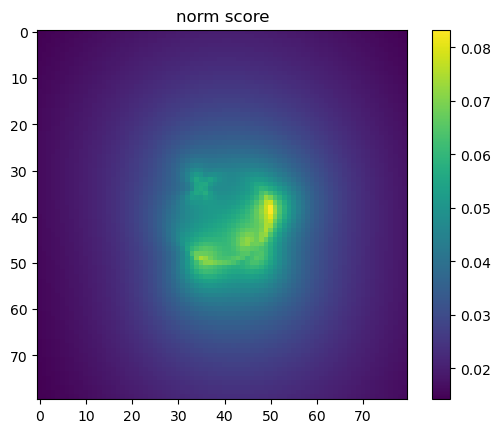

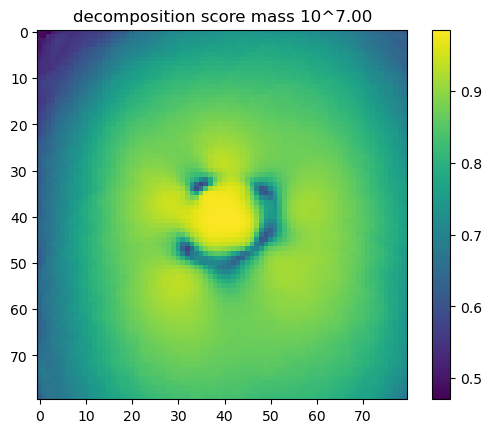

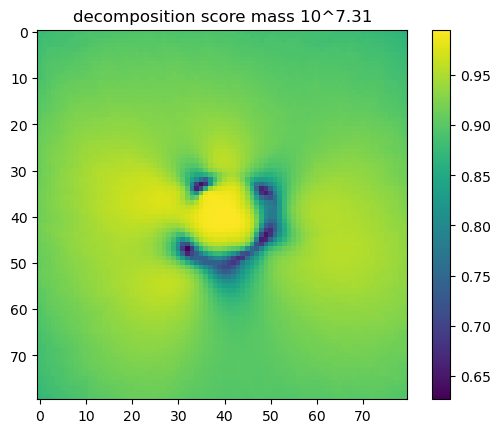

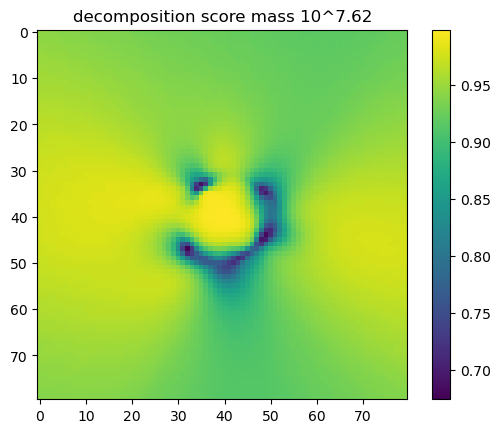

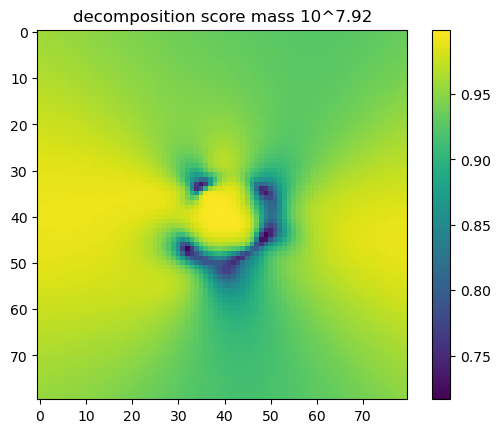

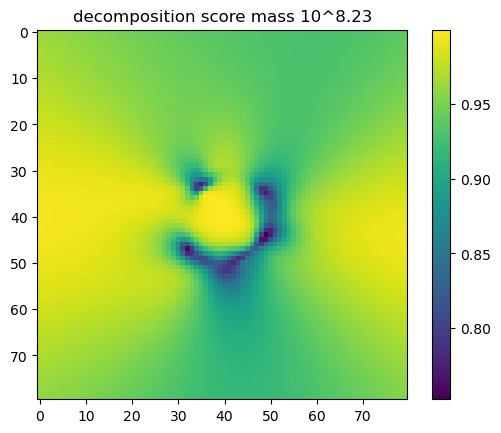

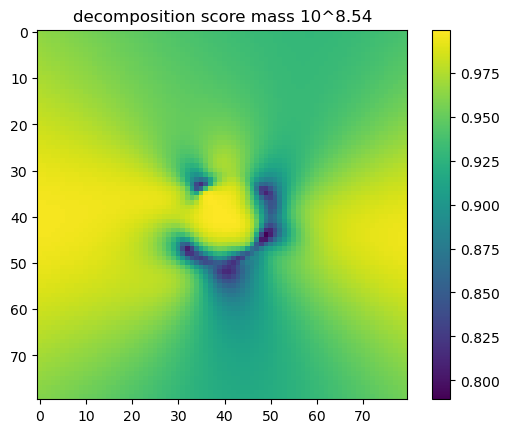

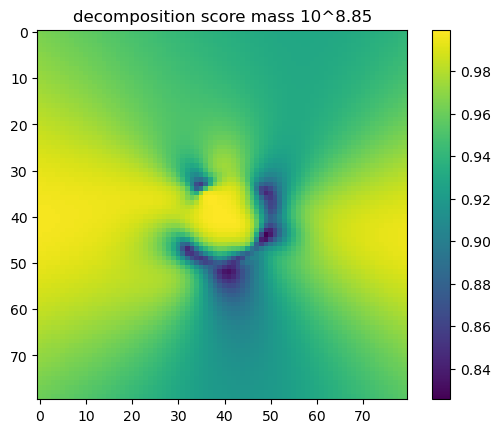

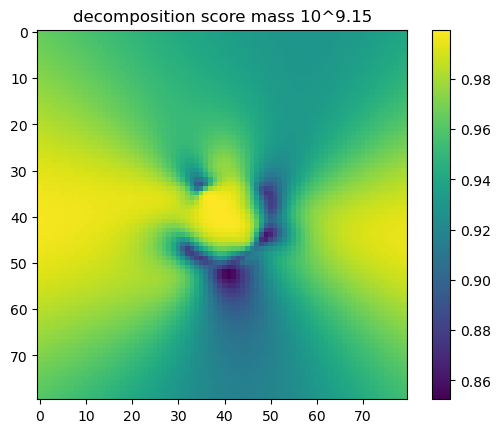

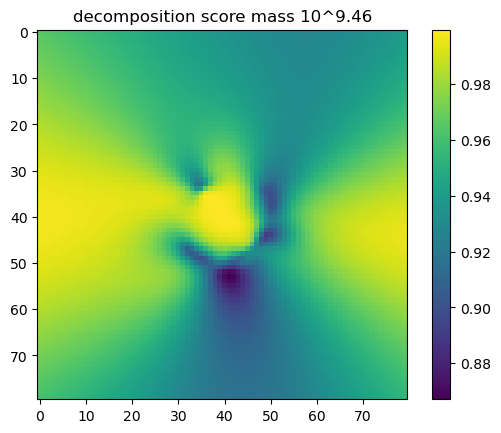

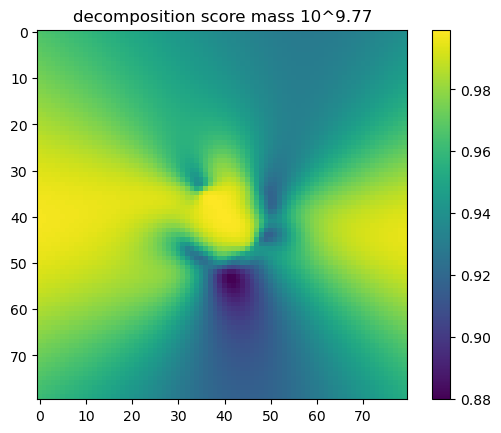

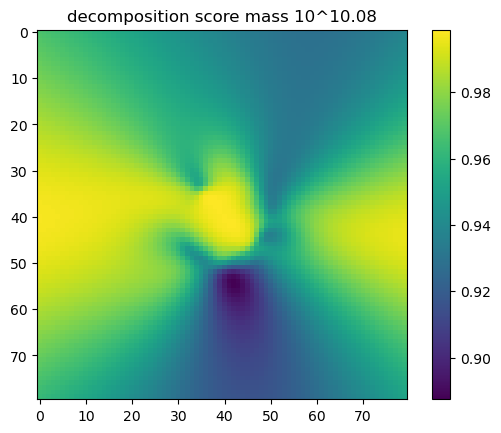

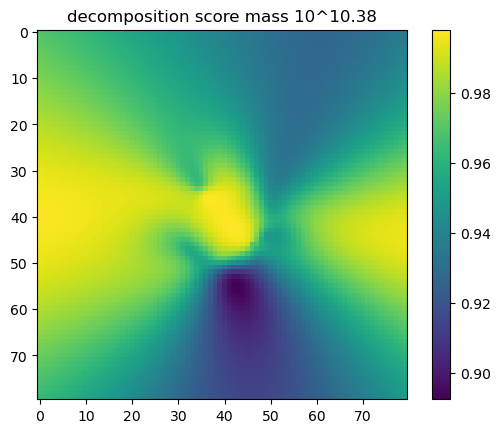

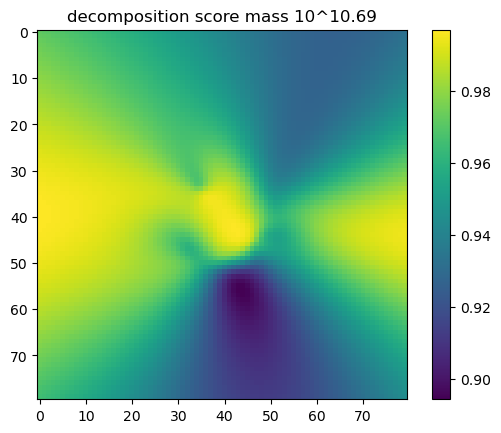

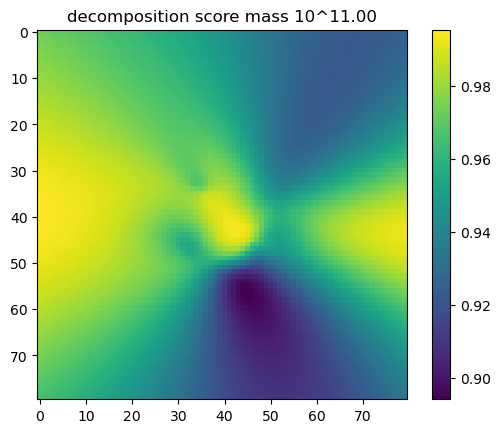

In [21]:
single_image_score=score_matrix[ :, :, :, 0]
decomposition_score=score_matrix[ :, :, :, 1]


coefficient=0.04

total_score=single_image_score-coefficient*(decomposition_score)

import matplotlib.pyplot as plt


plt.title("norm score")

plt.imshow(single_image_score[3])
plt.colorbar()
plt.show()
    
for i in range(14):
    plt.title(f"decomposition score mass 10^{(torch.linspace(7.,11., 14))[i]:.2f}")
    plt.imshow(decomposition_score[i])
    plt.colorbar()
    plt.show()

# plt.title("total score")

# plt.imshow(total_score[1])
# plt.colorbar()
# plt.show()
